In [2]:
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

In [3]:
diabetes = pd.read_csv('data/diabetes.csv')
diabetes.head()

,jHamil,jGlukosa,tekananDarah,ketebalanKulit,serumInsulin,IMB,RiyawatDiabetes,Umur,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
jHamil             768 non-null int64
jGlukosa           768 non-null int64
tekananDarah       768 non-null int64
ketebalanKulit     768 non-null int64
serumInsulin       768 non-null int64
IMB                768 non-null float64
RiyawatDiabetes    768 non-null float64
Umur               768 non-null int64
Outcome            768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


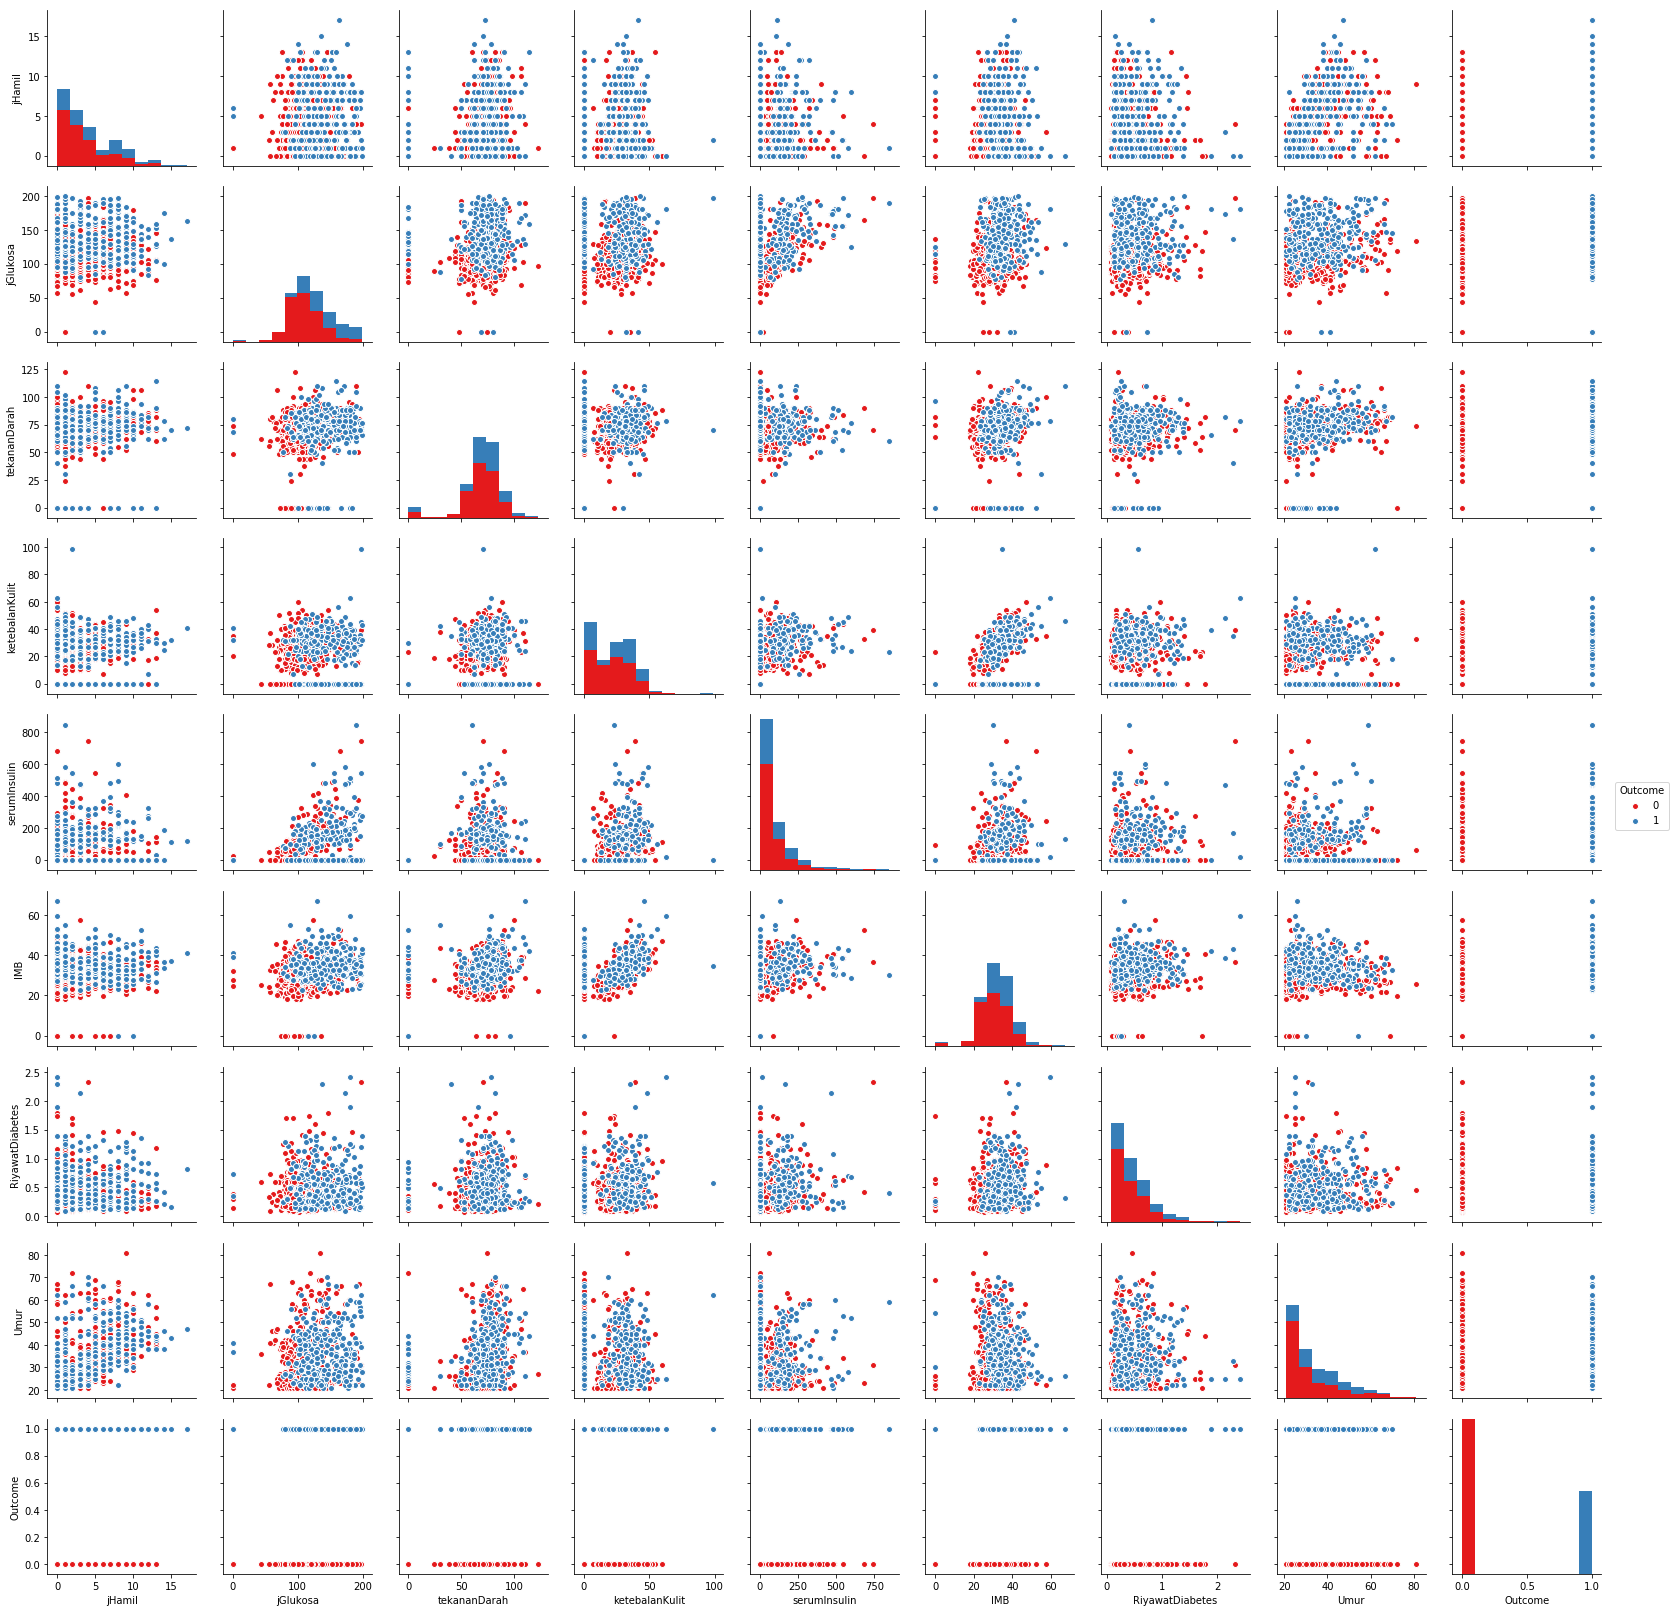

In [5]:
sns.pairplot(data=diabetes, hue='Outcome',palette="Set1")
plt.show()

In [6]:
# Display how many 0 value each feature have
for field in diabetes.columns[:8]:
    print('Number of 0-entries for "{field_name}" feature: {amount}'.format(
        field_name=field,
        amount=np.count_nonzero(diabetes[field] == 0)
    ))

Number of 0-entries for "jHamil" feature: 111
Number of 0-entries for "jGlukosa" feature: 5
Number of 0-entries for "tekananDarah" feature: 35
Number of 0-entries for "ketebalanKulit" feature: 227
Number of 0-entries for "serumInsulin" feature: 374
Number of 0-entries for "IMB" feature: 11
Number of 0-entries for "RiyawatDiabetes" feature: 0
Number of 0-entries for "Umur" feature: 0


Step 2: Feature Engineering

In [7]:
feature_names = diabetes.columns[:8]
feature_names

Index(['jHamil', 'jGlukosa', 'tekananDarah', 'ketebalanKulit', 'serumInsulin',
       'IMB', 'RiyawatDiabetes', 'Umur'],
      dtype='object')

In [8]:
X = diabetes[feature_names]
y = diabetes.Outcome

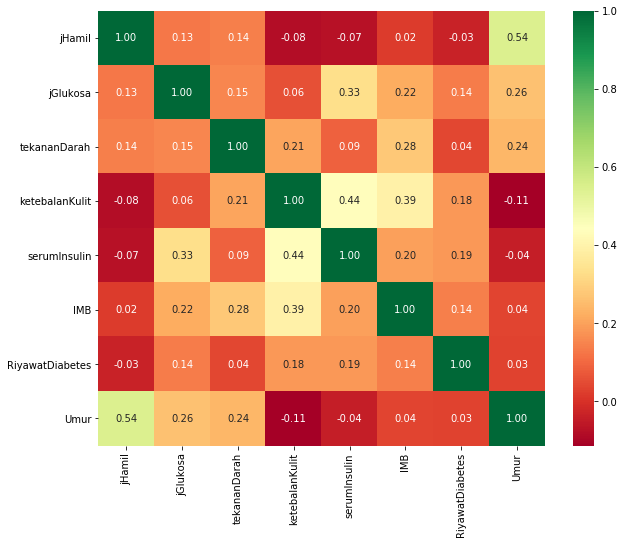

In [9]:
sns.heatmap(
    data=X.corr(),
    annot=True,
    fmt='.2f',
    cmap='RdYlGn'
)

fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.show()


Recursive Feature Elimination with Cross Validation

The goal of Recursive Feature Elimination (RFE) is to select features by feature ranking with recursive feature elimination.

For more confidence of features selection I used K-Fold Cross Validation with Stratified k-fold.


In [11]:
# I temporarily removed a few Glucose, BloodPressure and BMI rows with 0 values for better RFE result
diabetes_mod = diabetes[(diabetes.tekananDarah != 0) & (diabetes.IMB != 0) & (diabetes.jGlukosa != 0)]
diabetes_mod.shape

(724, 9)

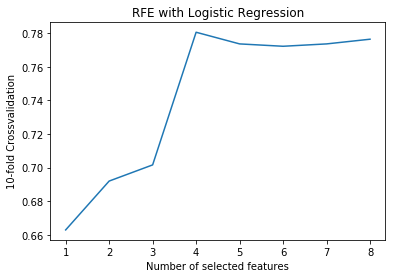

rfecv.grid_scores_: [0.66286712 0.69195875 0.70158638 0.78058771 0.77364273 0.77223428
 0.7736422  0.77644007]
rfecv.support_: [ True  True False False False  True  True False]

The most suitable features for prediction: ['jHamil', 'jGlukosa', 'IMB', 'RiyawatDiabetes']


In [12]:
X_mod = diabetes_mod[feature_names]
y_mod = diabetes_mod.Outcome

strat_k_fold = StratifiedKFold(
    n_splits=10,
    random_state=42
)

logreg_model = LogisticRegression()

rfecv = RFECV(
    estimator=logreg_model,
    step=1,
    cv=strat_k_fold,
    scoring='accuracy'
)
rfecv.fit(X_mod, y_mod)

plt.figure()
plt.title('RFE with Logistic Regression')
plt.xlabel('Number of selected features')
plt.ylabel('10-fold Crossvalidation')

# grid_scores_ returns a list of accuracy scores
# for each of the features selected
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

print('rfecv.grid_scores_: {grid_scores}'.format(grid_scores=rfecv.grid_scores_))

# support_ is another attribute to find out the features
# which contribute the most to predicting
new_features = list(filter(
    lambda x: x[1],
    zip(feature_names, rfecv.support_)
))

print('rfecv.support_: {support}'.format(support=rfecv.support_))

# Features are the most suitable for predicting the response class
new_features = list(map(operator.itemgetter(0), new_features))
print('\nThe most suitable features for prediction: {new_features}'.format(new_features=new_features))


Step 3: Data standardization¶

Standardize features by removing the mean and scaling to unit variance.


In [14]:
# Features chosen based on RFECV result
best_features = [
    'jHamil', 'jGlukosa', 'IMB', 'RiyawatDiabetes'
]

X = StandardScaler().fit_transform(X[best_features])

In [15]:
# Split your data into training and testing (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.20
)

In [16]:
pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print('PCA sum: {:.2f}%'.format(sum(pca.explained_variance_ratio_) * 100))

[0.33842817 0.25748883]
PCA sum: 59.59%



Step 4: Evaluating the performance of Logistic Regression model¶

For this case study I decided to use LogisticRegression classifier as a beginning of my Data Science trip.

Model Parameter Tuning with GridSearchCV returns the set of parameters which have an imperceptible impact on model evaluation.

You can check it by yourself:


In [17]:
from sklearn.model_selection import GridSearchCV

c_values = list(np.arange(1, 100))

param_grid = [
    {
        'C': c_values,
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'multi_class': ['ovr'],
        'random_state': [42]
    },
    {
        'C': c_values,
        'penalty': ['l2'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'multi_class': ['ovr'],
        'random_state': [42]
    }
]

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=strat_k_fold,
    scoring='f1'
)
grid.fit(X, y)

# Best LogisticRegression parameters
print(grid.best_params_)
# Best score for LogisticRegression with best parameters
print('Best score: {:.2f}%'.format(grid.best_score_ * 100))

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best score: 62.25%


In [18]:
log_reg = LogisticRegression(
    # Parameters chosen based on GridSearchCV result
    C=1,
    multi_class='ovr',
    penalty='l2',
    solver='newton-cg',
    random_state=42
)
log_reg.fit(X_train, y_train)

log_reg_predict = log_reg.predict(X_test)
log_reg_predict_proba = log_reg.predict_proba(X_test)[:, 1]

In [19]:


print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict_proba) * 100))
print('Classification report:\n\n', classification_report(y_test, log_reg_predict))
print('Training set score: {:.2f}%'.format(log_reg.score(X_train, y_train) * 100))
print('Testing set score: {:.2f}%'.format(log_reg.score(X_test, y_test) * 100))



Accuracy: 83.77%
AUC: 85.38%
Classification report:

              precision    recall  f1-score   support

          0       0.84      0.93      0.88        99
          1       0.84      0.67      0.75        55

avg / total       0.84      0.84      0.83       154

Training set score: 76.22%
Testing set score: 83.77%


In [20]:
confusion_matrix(y_test, log_reg_predict)

array([[92,  7],
       [18, 37]], dtype=int64)

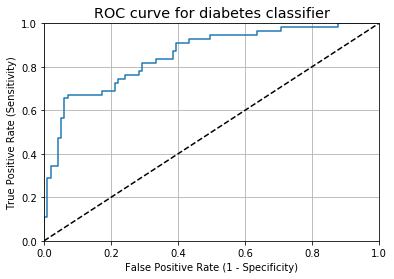

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, log_reg_predict_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)